In [25]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps
import csv

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [3]:
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

TRAIN_CORONAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_coronal_images")
TRAIN_CORONAL_LABEL_DIR = os.path.join(DATA_DIR, "train_coronal_labels")
TRAIN_SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images")
TRAIN_SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "train_sagittal_labels")

In [18]:
def read_sagittal_labels(UID):
    img_list = []
    for i in range(512):
        img = np.asarray(Image.open(os.path.join(TRAIN_SAGITTAL_LABEL_DIR, UID, f"{i}.png")))

        img_list.append(img)

    img_list = np.stack(img_list)
    return img_list

UID = "1.2.826.0.1.3680043.16935"
img_list = read_sagittal_labels(UID)
img_list.shape

(512, 256, 256)

보면 잘못 segment 된 부분도 꽤 있다. 8번 척추가 나온것을 볼 수 있다.

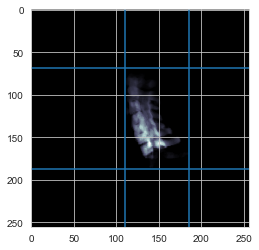

In [19]:
mean_sagittal = np.mean(img_list, axis=0)
x, y, z = img_list.nonzero()
plt.imshow(mean_sagittal, cmap='bone')
plt.axhline(y.min())
plt.axhline(y.max())
plt.axvline(z.min())
plt.axvline(z.max())
plt.show()

pixel spacing = 0.5136  => 0.2 로 맞추려고 하면 2-

In [20]:
def read_coronal_labels(UID):
    img_list = []
    for i in range(512):
        img = np.asarray(Image.open(os.path.join(TRAIN_CORONAL_LABEL_DIR, UID, f"{i}.png")))

        img_list.append(img)

    img_list = np.stack(img_list)
    return img_list

UID = "1.2.826.0.1.3680043.16935"
coronal_img_list = read_coronal_labels(UID)
coronal_img_list.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SSD970/train_coronal_labels/1.2.826.0.1.3680043.16935/0.png'

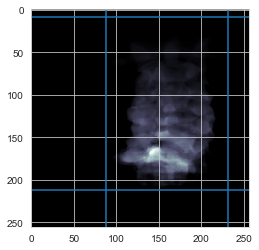

In [21]:
mean_coronal = np.mean(coronal_img_list, axis=0)

x, y, z = coronal_img_list.nonzero()
plt.imshow(mean_coronal, cmap='bone')
plt.axhline(y.min())
plt.axhline(y.max())
plt.axvline(z.min())
plt.axvline(z.max())
plt.show()

## write csv

In [26]:
def calculate_coronal_boundary(UID):
    img_list = read_coronal_labels(UID)
    x, y, z = img_list.nonzero()
    left, top, right, bottom = z.min(), y.min(), z.max(), y.max()
    return left, top, right, bottom

def calculate_sagittal_boundary(UID):
    img_list = read_sagittal_labels(UID)
    x, y, z = img_list.nonzero()
    left, top, right, bottom = z.min(), y.min(), z.max(), y.max()
    return left, top, right, bottom

In [30]:
header = [
    "UID",
    "coronal_left","coronal_top","coronal_right","coronal_bottom",
    "sagittal_left","sagittal_top","sagittal_right","sagittal_bottom",
]
f = open('meta_boundary.csv', 'w', newline='')
writer = csv.writer(f)
writer.writerow(header)

117

In [31]:
def calculate_boundary(UID):
    coronal_left, coronal_top, coronal_right, coronal_bottom = calculate_coronal_boundary(UID)
    sagittal_left, sagittal_top, sagittal_right, sagittal_bottom = calculate_sagittal_boundary(UID)

    writer.writerow([
        UID,
        coronal_left, coronal_top, coronal_right, coronal_bottom,
        sagittal_left, sagittal_top, sagittal_right, sagittal_bottom
    ])


In [32]:
vertical_label_dirs = glob.glob(TRAIN_SAGITTAL_LABEL_DIR + "/**")
for label_dir in tqdm(vertical_label_dirs):
    UID = label_dir.split("/")[-1]
    calculate_boundary(UID)

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


In [33]:
f.close()